In [21]:
import sys
sys.path.insert(0,"../")

In [22]:
from torch.utils.data import DataLoader
import torch

In [23]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [24]:
from core.model.model import MoCo
from core.dataloader import CLEVR_train, collate_boxes, CLEVR_train_onlyquery, collate_boxes_onlyquery
from core.utils import compute_features

In [25]:
kmeans_train_dataset = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5v.txt')
kmeans_train_loader = DataLoader(kmeans_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_boxes_onlyquery)

query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5v.txt')
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

Initialised..... 1134  files...
Initialised..... 63  files...


In [26]:
model = MoCo()
model = model.cuda()

In [27]:
PATH = "/home/mprabhud/saksham/non-metric_3d_representation/single_obj_exp_test/checkpoint.pth"
model.load_state_dict(torch.load(PATH)['state_dict'])

<All keys matched successfully>

In [28]:
class DoublePool_O():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        random.seed(125)
        if self.pool_size > 0:
            self.num = 0
            self.embeds = []
            self.scene_nums = []
            self.images = []
            #self.classes = []
            
    def fetch(self):
        return self.embeds, self.images, self.scene_nums #, self.classes,None, self.visual2D
            
    def is_full(self):
        full = self.num==self.pool_size
        # print 'num = %d; full = %s' % (self.num, full)
        return full
            
    def update(self, embeds, images, scene_nums, classes=None, vis2Ds=None):
        # embeds is B x ... x C
        # images is B x ... x 3

        #for embed, image, class_val,vis2D in zip(embeds, images,classes, vis2Ds):
        for embed, image, scene_num in zip(embeds, images, scene_nums):
            if self.num < self.pool_size:
                # the pool is not full, so let's add this in
                self.num = self.num + 1
            else:
                # the pool is full
                # pop from the front
                self.embeds.pop(0)
                self.images.pop(0)
                self.scene_nums.pop(0)
                #self.classes.pop(0)
                #self.visual2D.pop(0)
            # add to the back
            self.embeds.append(embed)
            self.images.append(image)
            self.scene_nums.append(scene_num)
            
            #self.classes.append(class_val)
            #self.visual2D.append(vis2D)
        # return self.embeds, self.images

In [29]:
for i, (feed_dict_q, feed_dict_k, metadata) in enumerate((query_train_loader)):
    break

../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [30]:
pool_size = 63
pool_e = DoublePool_O(pool_size)
pool_g = DoublePool_O(pool_size)

In [31]:
from tqdm import tqdm

def store_to_pool(eval_loader, model, args):
    print('Storing to pool...')
    model.eval()
    for i, (feed_dict_q, feed_dict_k, metadata) in enumerate(tqdm(eval_loader)):
        with torch.no_grad():
            feat_q = model(feed_dict_q, None, metadata, is_eval=True)
            feat_k = model(feed_dict_k, None, metadata, is_eval=True)

            pool_e.update(feat_q, feed_dict_q["images"], metadata["scene_number"],None, None)
            pool_g.update(feat_k, feed_dict_k["images"], metadata["scene_number"],None, None)
                
    return


In [32]:
store_to_pool(query_train_loader, model, None)

  0%|          | 0/63 [00:00<?, ?it/s]../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)
  5%|▍         | 3/63 [00:00<00:02, 22.79it/s]

Storing to pool...


100%|██████████| 63/63 [00:02<00:00, 23.84it/s]


In [62]:
from sklearn.neighbors import NearestNeighbors
def random_retrieve_topk(pool_e, pool_g, imgs_to_view=3):
    print("Fitting k-nearest-neighbour model on pool g...")
    knn = NearestNeighbors(n_neighbors=10, metric="cosine")
    knn.fit(torch.stack(pool_g.embeds).cpu())
    
    # select imgs_to_view images from pool q randomly
    query_indices_to_use = random.sample(range(0, pool_e.num), imgs_to_view)
    print(query_indices_to_use)

    # Perform image retrieval on test images
    print("Performing image retrieval on test images...")
    for i, index in enumerate(query_indices_to_use):

        _, indices = knn.kneighbors(torch.reshape(pool_e.embeds[index], (1,-1)).cpu()) # find k nearest train neighbours
        print(pool_e.scene_nums[index])
        img_query = pool_e.images[index].permute(1,2,0).cpu() # query image
        imgs_retrieval = [pool_g.images[idx].permute(1,2,0).cpu() for idx in indices.flatten()]# retrieval images
        print([pool_g.scene_nums[idx]..cpu() for idx in indices.flatten()])
        plot_query_retrieval(img_query, imgs_retrieval, None)
        

In [63]:
def plot_query_retrieval(img_query, imgs_retrieval, outFile):
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(2*n_retrieval, 4))
    fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

    # Plot query image
    ax = plt.subplot(2, n_retrieval, 0 + 1)
    plt.imshow(img_query)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(4)  # increase border thickness
        ax.spines[axis].set_color('black')  # set to black
    ax.set_title("query",  fontsize=14)  # set subplot title

    # Plot retrieval images
    for i, img in enumerate(imgs_retrieval):
        ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(1)  # set border thickness
            ax.spines[axis].set_color('black')  # set to black
        ax.set_title("Rank #%d" % (i+1), fontsize=14)  # set subplot title

    if outFile is None:
        plt.show()
    else:
        plt.savefig(outFile, bbox_inches='tight')

Fitting k-nearest-neighbour model on pool g...
Performing image retrieval on test images...
tensor(29)
[tensor(29), tensor(11), tensor(61), tensor(40), tensor(0), tensor(46), tensor(17), tensor(58), tensor(6), tensor(18)]


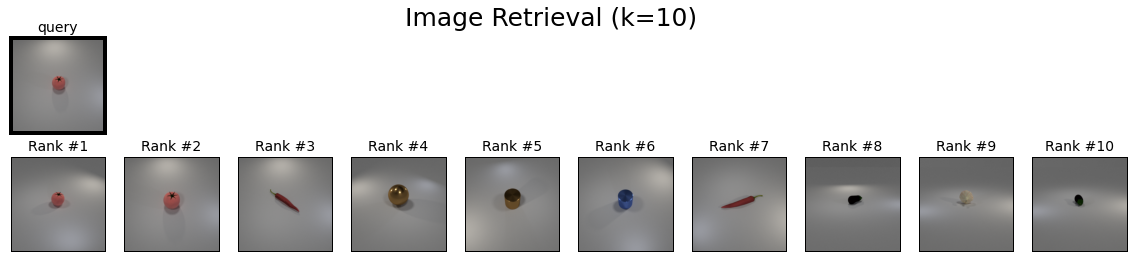

tensor(15)
[tensor(53), tensor(15), tensor(59), tensor(22), tensor(56), tensor(60), tensor(42), tensor(24), tensor(30), tensor(41)]


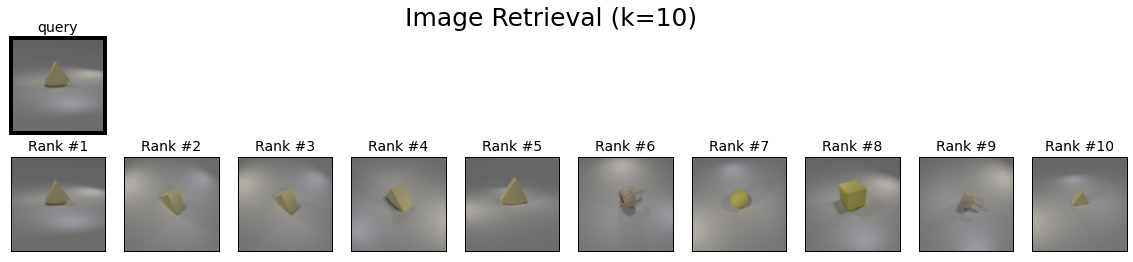

tensor(5)
[tensor(5), tensor(51), tensor(33), tensor(50), tensor(31), tensor(13), tensor(28), tensor(38), tensor(45), tensor(24)]


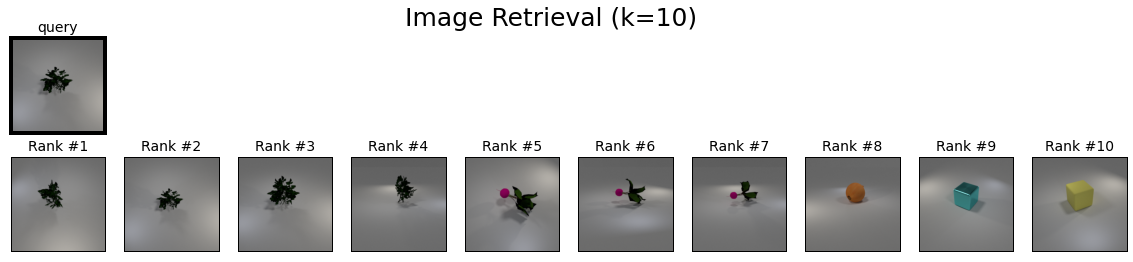

In [64]:
random_retrieve_topk(pool_e, pool_g, imgs_to_view=3)

In [60]:
from sklearn.neighbors import NearestNeighbors
def random_retrieve_topk(pool_e, pool_g, imgs_to_view=3):
    print("==> Fitting k-nearest-neighbour model on pool g...")
    knn = NearestNeighbors(n_neighbors=10, metric="cosine")
    knn.fit(torch.stack(pool_g.embeds).cpu())
    
    # select imgs_to_view images from pool q randomly
    query_indices_to_use = random.sample(range(0, pool_e.num), imgs_to_view)
    
    
    figures_gen = []
    print(query_indices_to_use)

    # Perform image retrieval on test images
    print("==> Performing image retrieval on test images...")
    for i, index in enumerate(query_indices_to_use):
        temp = []
        _, indices = knn.kneighbors(torch.reshape(pool_e.embeds[index], (1,-1)).cpu()) # find k nearest train neighbours
        #print(pool_e.scene_nums[index])
        img_query = pool_e.images[index].permute(1,2,0).cpu() # query image
        temp.append(img_query)
        imgs_retrieval = [pool_g.images[idx].permute(1,2,0).cpu() for idx in indices.flatten()]# retrieval images
        temp.extend(imgs_retrieval)
        #print([pool_g.scene_nums[idx].cpu() for idx in indices.flatten()])
        figures_gen.append(temp)
    fig = plot_query_retrieval(figures_gen, None)
        
    return fig
        

def plot_query_retrieval(imgs_retrieval, outFile):
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(20, 4))
    for idx in range(3):
        for im in range(0, 11):
            ax = fig.add_subplot(3, 11, 11*idx+im+1,xticks=[], yticks=[])
            ax.imshow(imgs_retrieval[idx][im])
            if im==0:
                ax.set_title('Query')
            else:
                ax.set_title('Top_'+str(im))
    #plt.close(fig)
    return fig

==> Fitting k-nearest-neighbour model on pool g...
[29, 15, 5]
==> Performing image retrieval on test images...


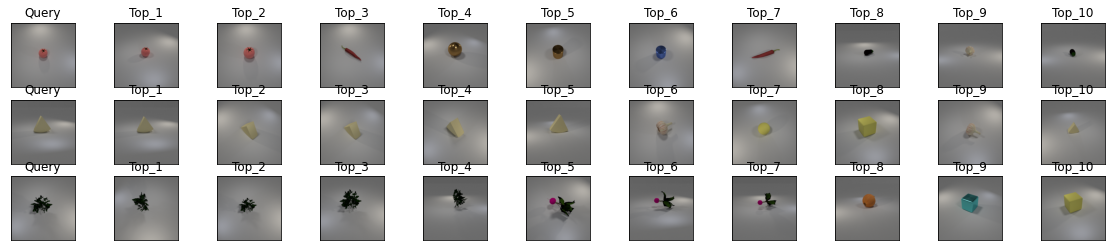

In [61]:
_ = random_retrieve_topk(pool_e, pool_g, 3)